<a href="https://colab.research.google.com/github/gmxavier/TEP-meets-LSTM/blob/master/using-tep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using [`tep`](https://github.com/gmxavier/TEP-meets-LSTM/tree/master/tep)

`tep` is a R wrapper for the TEP test problem originally written by Downs and Vogel (1990) with modifications by Russell, Chiang and Braatz (2002) and Xavier (2018).

If you are developing derived works based on `tep`, please cite the this paper [here](https://ieeexplore.ieee.org/document/8489385).

`tep` is written in R and was the first open source language wrapper for the TEP test problem, followed by [`tep2py`](https://github.com/camaramm/tep2py) written in Python.

The core of both wrappers is [this](https://github.com/gmxavier/TEP-meets-LSTM/blob/master/tep/src/temain.f) modified `temain.f` file.



First let's get all files we will need (`temain.f`, `teprob.f` and `tep.R`)

In [1]:
# to get the files
from requests import get
repo_url = 'https://raw.githubusercontent.com/gmxavier/TEP-meets-LSTM/master/tep/'
for file in ['temain.f', 'teprob.f', 'tep.R']:
  url = repo_url+'src/'+file
  if file == 'tep.R':
    url = repo_url+'R/'+file
  with open(file, 'w') as f: 
    f.write(get(url).text)

Since the R function `tep` is based on FORTRAN codes, the first thing is compile the source codes.

In [2]:
# to compile the temain.f
!gfortran -fPIC -c teprob.f
!gfortran -fPIC -shared -o temain.so temain.f teprob.o -lm -lc

As we want to show the usage of R wrapper `tep` within this Jupyter notebook, we need to load R using the package `rpy2` and the R magic

In [3]:
# to use R
!pip install rpy2
%load_ext rpy2.ipython

Now we load the compiled Fortran library, the R wrapper and list its functions: `tep` and `tepAttrib`.

In [4]:
%%R
dyn.load('temain.so')
source('tep.R')
ls(all.names = TRUE)

[1] "tep"       "tepAttrib"


The `tepAttrib` function is just informative. A list of all 52 variables is given when we call it without any argument.

> Note: As the agitator speed is constant, it is not listed or even available for simulation.

In [5]:
%%R
tepAttrib()

      variable    description                                unit    
 [1,] "XMEAS(1)"  "A Feed (stream 1)"                        "kscmh" 
 [2,] "XMEAS(2)"  "D Feed (stream 2)"                        "kg h-1"
 [3,] "XMEAS(3)"  "E Feed (stream 3)"                        "kg h-1"
 [4,] "XMEAS(4)"  "A and C Feed (stream 4)"                  "kscmh" 
 [5,] "XMEAS(5)"  "Recycle Flow (stream 8)"                  "kscmh" 
 [6,] "XMEAS(6)"  "Reactor Feed Rate"                        "kscmh" 
 [7,] "XMEAS(7)"  "Reactor Pressure"                         "kPa"   
 [8,] "XMEAS(8)"  "Reactor Level"                            "%"     
 [9,] "XMEAS(9)"  "Reactor Temperature"                      "oC"    
[10,] "XMEAS(10)" "Purge Rate (stream 9)"                    "kscmh" 
[11,] "XMEAS(11)" "Product Sep Temp"                         "oC"    
[12,] "XMEAS(12)" "Product Sep Level"                        "%"     
[13,] "XMEAS(13)" "Prod Sep Pressure"                        "kPa"   
[14,] "XMEAS(14)" "P

The `tep` function is the true work horse. Its main argument is the `idata` matrix, which is a binary indicator matrix where the rows are the time steps and the columns are the faults.

> Note: For example, to simulate 60 time steps (or 180 min in total, as the sampling time is 3 min) where only the fault #1 occurs, we will need a `idata` matrix with 60 rows and 20 columns. All the entries of this matrix are 0, except the ones corresponding to column #1, which are all equal to 1.

In [6]:
%%R
idata <- matrix(0L, nrow = 60, ncol = 20)
idata[1:30,1] <- 1L
xdata <- tep(idata)

And finally we can plot, for example, the process history of the stripper temperature (`XMEAS(18)`).

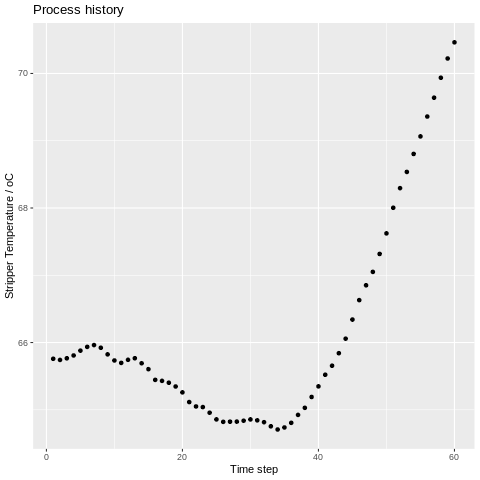

In [7]:
%%R
library(ggplot2)
ii <- 18L
desc <- tepAttrib(i=ii)
ggplot() +
    geom_point(data=as.data.frame(xdata), aes(x=1:nrow(xdata), y=xdata[,ii])) + 
    ggtitle('Process history') + 
    xlab('Time step') + ylab(paste(desc[[2]],'/',desc[[3]]))